## Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split #
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize, OneHotEncoder



## Načítanie dát

In [ ]:
dataset = pd.read_csv('../Data/final_dataset_3.csv')

## Rozdelenie dát

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoding

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

## TextVectorization

In [ ]:
embedding_dim = 256
vocab_size = 60000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(dataset['processed_text'].values)

### Model 1 - LSTM+GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=True)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 6000)              0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 lstm_5 (LSTM)               (None, 6000, 256)         525312    
                                                                 
 dropout_11 (Dropout)        (None, 6000, 256)         0         
                                                                 
 gru_2 (GRU)                 (None, 6000, 128)         148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size = 8, callbacks=[model_checkpoint_callback])

Epoch 1/10
176/176 [==============================] - 108s 588ms/step - loss: 2.7547 - accuracy: 0.1944 - val_loss: 2.5961 - val_accuracy: 0.2949
Epoch 2/10
176/176 [==============================] - 102s 582ms/step - loss: 1.8423 - accuracy: 0.4544 - val_loss: 1.3747 - val_accuracy: 0.5641
Epoch 3/10
176/176 [==============================] - 105s 594ms/step - loss: 1.2244 - accuracy: 0.6047 - val_loss: 1.3110 - val_accuracy: 0.5833
Epoch 4/10
176/176 [==============================] - 100s 566ms/step - loss: 0.9059 - accuracy: 0.7066 - val_loss: 1.2405 - val_accuracy: 0.5833
Epoch 5/10
176/176 [==============================] - 100s 567ms/step - loss: 0.8295 - accuracy: 0.7400 - val_loss: 0.9551 - val_accuracy: 0.6603
Epoch 6/10
176/176 [==============================] - 84s 476ms/step - loss: 0.7129 - accuracy: 0.7899 - val_loss: 1.2433 - val_accuracy: 0.6346
Epoch 7/10
176/176 [==============================] - 83s 474ms/step - loss: 0.5528 - accuracy: 0.8234 - val_loss: 1.1441 - v

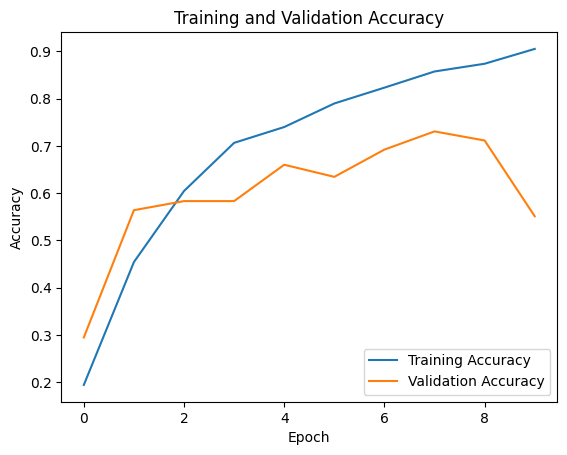

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 4s 224ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6572890025575447
F1 Score: 0.6551691295799255
Precision: 0.755202688960453
Recall: 0.6572890025575447


### Model 2 - BIDIRECTIONAL LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 bidirectional (Bidirection  (None, 6000, 256)         394240    
 al)                                                             
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                         
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
176/176 [==============================] - 91s 490ms/step - loss: 2.5138 - accuracy: 0.1909 - val_loss: 2.0296 - val_accuracy: 0.2885
Epoch 2/10
176/176 [==============================] - 83s 469ms/step - loss: 1.6591 - accuracy: 0.4195 - val_loss: 1.4910 - val_accuracy: 0.5064
Epoch 3/10
176/176 [==============================] - 85s 484ms/step - loss: 1.1333 - accuracy: 0.5969 - val_loss: 1.1544 - val_accuracy: 0.5385
Epoch 4/10
176/176 [==============================] - 82s 467ms/step - loss: 0.7717 - accuracy: 0.7251 - val_loss: 0.9179 - val_accuracy: 0.6474
Epoch 5/10
176/176 [==============================] - 81s 460ms/step - loss: 0.5489 - accuracy: 0.8148 - val_loss: 0.6562 - val_accuracy: 0.7628
Epoch 6/10
176/176 [==============================] - 82s 466ms/step - loss: 0.4671 - accuracy: 0.8405 - val_loss: 0.8793 - val_accuracy: 0.7308
Epoch 7/10
176/176 [==============================] - 82s 466ms/step - loss: 0.3407 - accuracy: 0.8868 - val_loss: 0.6894 - val_ac

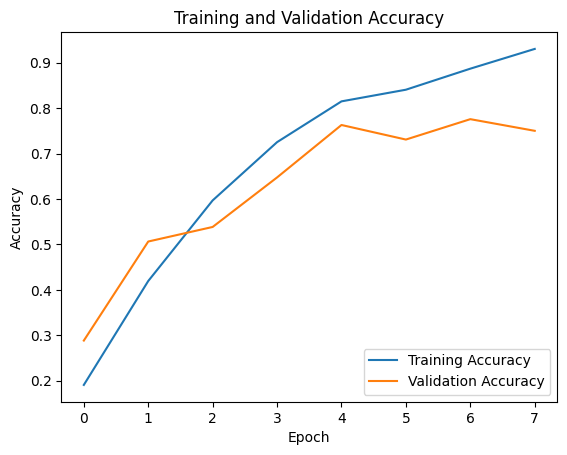

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 3s 175ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.782608695652174
F1 Score: 0.7852522260324426
Precision: 0.8285661714932141
Recall: 0.782608695652174


### Model 3 - LSTM

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(vocab_size, embedding_dim)(x_v)
x = keras.layers.LSTM(512, return_sequences=True)(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(246)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 6000, 256)         15360000  
                                                                 
 lstm_2 (LSTM)               (None, 6000, 128)         197120    
                                                                 
 dropout_5 (Dropout)         (None, 6000, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback, stop], epochs=10, batch_size=8)

Epoch 1/10
176/176 [==============================] - 83s 448ms/step - loss: 2.8356 - accuracy: 0.0969 - val_loss: 2.8038 - val_accuracy: 0.1090
Epoch 2/10
176/176 [==============================] - 77s 438ms/step - loss: 2.6698 - accuracy: 0.1339 - val_loss: 2.7847 - val_accuracy: 0.1154
Epoch 3/10
176/176 [==============================] - 78s 444ms/step - loss: 2.4256 - accuracy: 0.2037 - val_loss: 2.9135 - val_accuracy: 0.1282
Epoch 4/10
176/176 [==============================] - 79s 447ms/step - loss: 2.0527 - accuracy: 0.3177 - val_loss: 3.1520 - val_accuracy: 0.1474
Epoch 5/10
176/176 [==============================] - 76s 430ms/step - loss: 1.7902 - accuracy: 0.4167 - val_loss: 3.3486 - val_accuracy: 0.1154


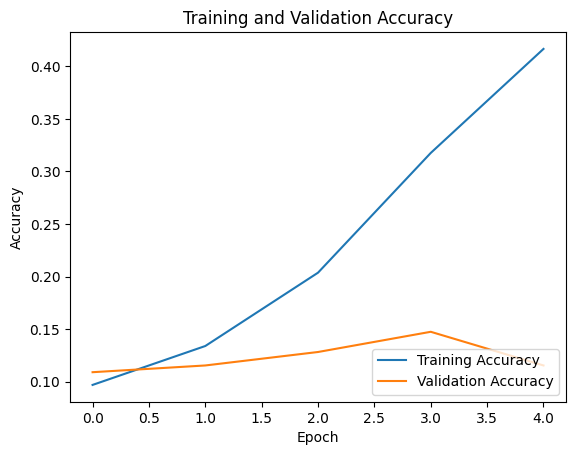

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

13/13 [==============================] - 3s 181ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.17902813299232737
F1 Score: 0.14035071282507816
Precision: 0.19229928686450426
Recall: 0.17902813299232737
